In [21]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import make_interp_spline
import scipy.stats as stats
from scipy.stats import norm
from scipy.stats import chi2
sns.set()

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

# Dataframe

In [22]:
dfEU_Growth = pd.read_pickle('EU_Growth.pkl')
dfPath = pd.read_pickle('Path.pkl')
df = dfPath.merge(dfEU_Growth, on='Date')

### Generate Lags

In [23]:
df['L1_Growth'] = df['Growth'].shift(1)

for i in range(1,9):
    df['L'+str(i)+'_Path'] = df['Path'].shift(i)
    
df = df.dropna()

# Autoregressive Distributed Lag (ARDL) Model

In [24]:
def ARDL(df):

    y = df['Growth'].values
    y = np.insert(y, 0, df['L1_Growth'][0])
    X = df[['Path', 'L1_Path', 'L2_Path', 'L3_Path', 'L4_Path', 'L5_Path', 'L6_Path', 'L7_Path', 'L8_Path']].values
    
    cX = sm.add_constant(np.insert(X, 0, y[:-1], axis=1))
    model = sm.OLS(y[1:], cX)
    results = model.fit()
    print(results.summary())

In [25]:
ARDL(df)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.637
Method:                 Least Squares   F-statistic:                     7.829
Date:                Tue, 16 Feb 2021   Prob (F-statistic):           6.22e-06
Time:                        16:30:00   Log-Likelihood:                -71.454
No. Observations:                  40   AIC:                             164.9
Df Residuals:                      29   BIC:                             183.5
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3247      0.315      1.031      0.3

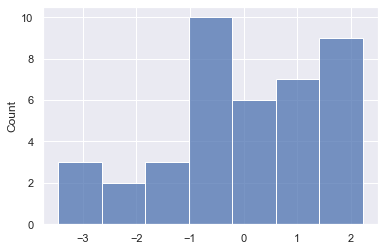

In [26]:
sns.histplot(pd.DataFrame(results.resid), legend=None);

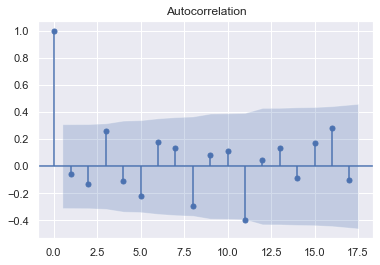

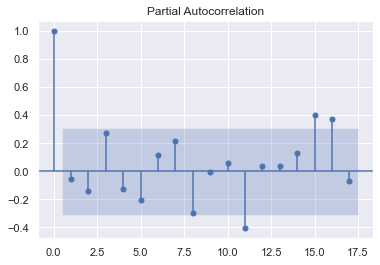

In [27]:
plot_acf(results.resid), plot_pacf(results.resid);

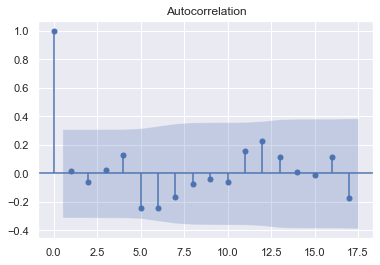

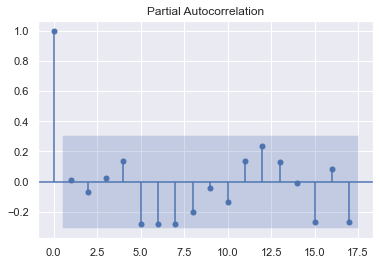

In [28]:
plot_acf(results.resid**2), plot_pacf(results.resid**2);

# Dynamic Multiplier

In [29]:
def ARDL_DynamicMultiplier(X, y, lags, periods):

    cX = sm.add_constant(np.insert(X, 0, y[:-1], axis=1))
    model = sm.OLS(y[1:], cX)
    results = model.fit()
    
    IRF = np.zeros(periods)
    
    for i in range(periods):
            if i < lags:
                IRF[i] = results.params[1]*IRF[i-1] + results.params[2+i]
            if i >= lags:
                IRF[i] = results.params[1]*IRF[i-1]

    # Delta Method Matrix
    G = np.zeros((periods, lags + 1))

    for i in range(0, periods):
        if i < lags:
            for n in range(i+1):
                G[i,0] += (i-n)*results.params[1]**(i-1-n)*results.params[2+n]
        if i >= lags:
            for n in range(G.shape[1]-1):
                G[i,0] += (i-n)*results.params[1]**(i-1-n)*results.params[2+n]
        if i < lags:
            for j in range(i+1):
                G[i,j+1] =results.params[1]**(i-j)
        if i >= lags:
            for j in range(lags):
                G[i,j+1] =results.params[1]**(i-j)

    # IRF Standard Errors
    Cov = G.dot(results.cov_params()[1:11, 1:11]).dot(G.T)

    SE = np.zeros(periods)
    for i in range(periods):
        SE[i] = np.sqrt(Cov[i,i])

    Upper5 = IRF + 1.96*SE
    Lower5 = IRF - 1.96*SE
    Upper10 = IRF + 1.645*SE
    Lower10 = IRF - 1.645*SE
    Upper1 = IRF + 2.576*SE
    Lower1 = IRF - 2.576*SE
    
    # IRF Plot
    fig, ax = plt.subplots()
    ax.plot(np.linspace(0, periods-1, num=periods), IRF)
    ax.fill_between(np.linspace(0, periods-1, num=periods), Upper5, Lower5, color='b', alpha=.1)
    ax.fill_between(np.linspace(0, periods-1, num=periods), Upper10, Lower10, color='b', alpha=.1)
    ax.fill_between(np.linspace(0, periods-1, num=periods), Upper1, Lower1, color='b', alpha=.1);

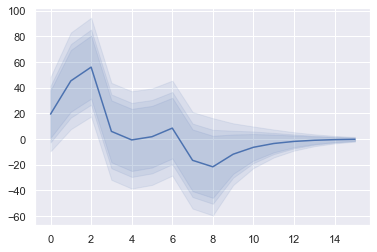

In [30]:
ARDL_DynamicMultiplier(X, y, 9, 16)

# Residual Bootstrap

In [31]:
def ARDL_ResidualBootstrap(X, y, iterations):
    
    list_dicts = []
    
    cX = sm.add_constant(np.insert(X, 0, y[:-1], axis=1))
    model = sm.OLS(y[1:], cX)
    results = model.fit()
    
    t_test = results.tvalues[2:]
    y_bstrp = np.zeros(len(y))
    cons = results.params[0]
    b = results.params[1:]
    r = results.resid
    
    R = np.eye(len(results.params))[2:]
    A = np.dot(R, results.params)
    B = np.linalg.multi_dot([R, results.cov_params(), R.T])
    Wald = np.linalg.multi_dot([A.T, np.linalg.inv(B), A])
    
    np.random.seed(0)

    iterations = 1000

    for k in range(0, iterations):

        # Generate Bootstrapped Errors
        r_bstrp = np.random.choice(r, len(r)) 
        l_y = y[0]
        y_bstrp[0] = y[0]

        # Generate Bootstrapped Dependent Variable
        for i in range(1, len(y)):
            y_bstrp[i] = cons + np.dot(b, np.insert(X[i-1], 0, l_y)) + r_bstrp[i-1]
            l_y = y_bstrp[i]

        # Estimation
        cX_bstrp = sm.add_constant(np.insert(X, 0, y_bstrp[:-1], axis=1))
        model = sm.OLS(y_bstrp[1:], cX_bstrp)
        results = model.fit()

        # Store t-tests
        for j in range(X.shape[1]):
            t = (results.params[j+2]-b[j+1])/results.bse[j+2]
            curr_dict = {'t_test'+str(j): t}
            list_dicts.append(curr_dict)

        # Store Wald Test
        A = np.dot(R, results.params - np.insert(b, 0, cons))
        B = np.linalg.multi_dot([R, results.cov_params(), R.T])
        W = np.linalg.multi_dot([A.T, np.linalg.inv(B), A])
        curr_dict = {'Wald_test': W}
        list_dicts.append(curr_dict)

    Bstrap = pd.DataFrame(list_dicts)
    for i in list(Bstrap):
        Bstrap[i] = Bstrap[i].dropna().reset_index(drop=True)
    
    dfBootstrap = Bstrap.dropna()
    return dfBootstrap

In [32]:
dfBootstrap=ARDL_ResidualBootstrap(X, y, 1000)

In [33]:
dfBootstrap

,t_test0,t_test1,t_test2,t_test3,t_test4,t_test5,t_test6,t_test7,t_test8,Wald_test
0,1.717813,-1.062442,-0.833164,0.014867,-0.526369,-0.958335,-0.268550,-0.078914,0.595090,6.951987
1,0.181594,0.432271,1.361272,1.293856,-0.527031,-0.586314,-0.285077,-0.183451,-1.125195,3.823608
2,-0.903458,-1.448563,-0.719040,-0.654773,-0.350162,-0.034305,0.427585,0.100503,0.691217,3.599181
3,0.586996,1.279746,1.238161,-0.269953,0.601577,0.558856,1.276187,-0.444919,-0.066651,6.421170
4,-0.372015,-0.952322,-0.911673,-1.945975,-1.567161,0.890688,2.409795,-1.701115,-0.104735,14.657594
...,...,...,...,...,...,...,...,...,...,...
995,-0.624235,-1.416539,-0.826707,0.203064,0.882485,-0.493240,-2.013724,-0.589423,-1.024030,8.682890
996,0.855019,0.637327,2.020624,0.501091,1.568607,0.443434,0.537697,1.253746,0.900357,9.234623
997,-0.629738,-0.998520,-0.042659,0.591709,-0.376245,1.695201,1.091504,0.116241,-0.273674,6.238432
998,0.926525,0.500959,1.029347,0.292027,1.797499,0.147435,-0.457503,0.587574,1.974642,8.624592


In [34]:
def PlotDist_ResidualBootstrap(dfBootstrap, column):
    
    if 't_test' in column:
        fit=norm
    elif 'Wald_test' in column:
        fit=chi2
        
    ax = sns.distplot(dfBootstrap[column], fit=fit)
    ax.set(xlabel=column, ylabel='Frequency Density'); 
    print('Mean =', dfBootstrap[column].mean())
    if fit==norm:
        print('Critical values at 5% level =', np.quantile(dfBootstrap[column], 0.025), ',', np.quantile(dfBootstrap[column], 0.975))
    elif fit==chi2:
        print('Critical value at 5% level =', np.quantile(dfBootstrap[column], 0.95))

C:\Users\andre\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Mean = -0.01795708057806298
Critical values at 5% level = -1.8537278165170916 , 2.108424325066736


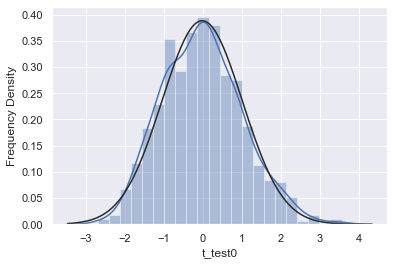

In [35]:
PlotDist_ResidualBootstrap(dfBootstrap, 't_test0')

C:\Users\andre\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Mean = 9.551908350069631
Critical value at 5% level = 19.529011942871655


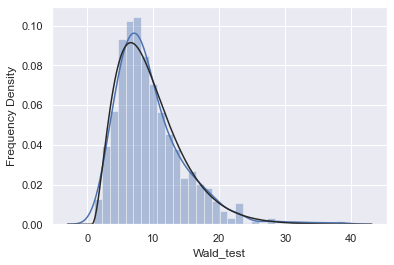

In [36]:
PlotDist_ResidualBootstrap(dfBootstrap, 'Wald_test')